### Evaluating SNAPHU's Unwrapping of Simulated Interferograms 

In [93]:
if "NOTEBOOK_INITIATED_FLAG" not in globals():
    NOTEBOOK_INITIATED_FLAG = True
    %cd ..
%pwd

from os import system
from array import array

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)

from insar_eventnet.sarsim import (
    gen_simulated_deformation,
    gen_sim_noise,
    Okada,
    gen_gaussian_noise,
)
from insar_eventnet.sarsim import (
    gen_fake_topo,
    atm_topo_simulate,
    aps_simulate,
    coherence_mask_simulate,
)


def display_images(phase, wrapped_phase, phase_pred):
    print("Max/Min Phase:  ", np.max(phase), np.min(phase))
    print("Max/Min SNAPHU: ", np.max(phase_pred), np.min(phase_pred))
    print("Max Diff: ", np.abs(np.max(phase) - np.max(phase_pred)))
    print("Min Diff: ", np.abs(np.min(phase) - np.min(phase_pred)))

    fig, [axs_wrapped, axs_phase, axs_phase_pred] = plt.subplots(1, 3)
    axs_wrapped.set_title("Wrapped")
    axs_wrapped.imshow(wrapped_phase, cmap="jet")
    axs_phase.set_title("True Phase")
    axs_phase.imshow(phase, cmap="jet")
    axs_phase_pred.set_title("Predicted Phase")
    axs_phase_pred.imshow(phase_pred, cmap="jet")


def unwrap_with_snaphu(
    wrapped: np.ndarray,
    tile_size: int = 512,
    wrapped_filename: str = "wrapped.bin",
    output_filename: str = "phase.tif",
    delete_files: bool = False,
    quiet: bool = False,
) -> np.ndarray:
    snaphu_output_fn = "snaphu.out"

    with open(wrapped_filename, "wb") as wrapped_file:
        wrapped = wrapped.flatten().astype("float32")
        w_tofile = array("f", wrapped).tofile(wrapped_file)

    quiet_str = "> /dev/null" if quiet else ""

    system(
        f'snaphu -C "INFILEFORMAT FLOAT_DATA" -t {wrapped_filename} {tile_size} {quiet_str}'
    )

    with open(snaphu_output_fn, "rb") as snaphu_file:
        phase_data = np.fromfile(snaphu_file, dtype="float32")
        phase = np.reshape(phase_data, (512, 2, 512))[:, 1, :]

    if delete_files:
        system(f"rm {wrapped_filename} snaphu.out")

    return phase

In [94]:
seed = 123456
if seed != 0:
    np.random.seed(seed)

tile_size = 512  # img size is (tile_size, tile_size)
event_type = "quake"  # quake, sill, or dyke

source_x = 40000  # min_x, max_x is 0->45000 at (512, 512)
source_y = 1000  # min_y, max_y is 0->45000 at (512, 512)

kwargs = {
    "strike": 180,  # for source_type 'quake'}
    "dip": 45,  # for source_type 'quake'
    "length": 2000,  # for source_type 'quake'
    "rake": 90,  # for source_type 'quake'
    "slip": 1,  # for source_type 'quake'
    "top_depth": 4000,  # for source_type 'quake'
    "bottom_depth": 8000,  # for source_type 'quake'
    "width": 2000,  # for source_type 'sill' and 'dyke'
    "depth": 4000,  # for source_type 'sill' and 'dyke'
    "opening": 0.5,  # for source_type 'sill' and 'dyke',
    "source_x": source_x,
    "source_y": source_y,
}

In [95]:
Event = Okada(event_type, (source_x, source_y), tile_size=tile_size, **kwargs)

scalar = 1000 * np.pi
los_displacement = Event.los_displacement
phase = scalar * los_displacement
wrapped_phase = np.angle(np.exp(1j * (phase)))

#### Unwrapping with No Noise Sources

In [96]:
pred_phase = unwrap_with_snaphu(wrapped_phase, quiet=True, delete_files=True)

Max/Min Phase:   164.9254391446654 -1.126159141006029
Max/Min SNAPHU:  164.92543 -1.126159
Max Diff:  8.846813841500989e-06
Min Diff:  1.882930162899754e-07


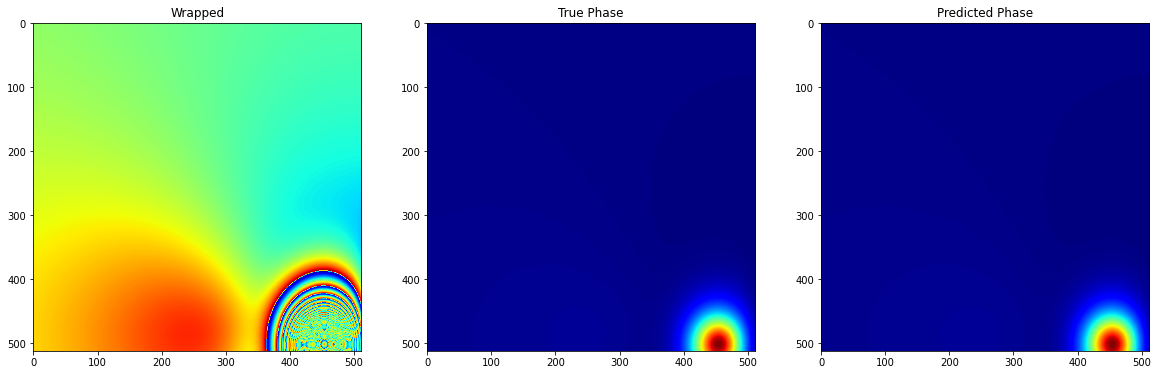

In [97]:
display_images(phase, wrapped_phase, pred_phase)

#### Unwrapping with Error from Turbulent Atmospheres

In [98]:
atmosphere_scalar = 90 * np.pi
turb_phase = aps_simulate(tile_size) * atmosphere_scalar / 2
phase_with_turb = phase + turb_phase
wrapped_with_turb = np.angle(np.exp(1j * (phase_with_turb)))
pred_phase_with_turb = unwrap_with_snaphu(
    wrapped_with_turb, quiet=True, delete_files=True
)

Max/Min Phase:   164.9254391446654 -1.126159141006029
Max/Min SNAPHU:  171.22604 3.8574824
Max Diff:  6.300604556506471
Min Diff:  4.983641574325121


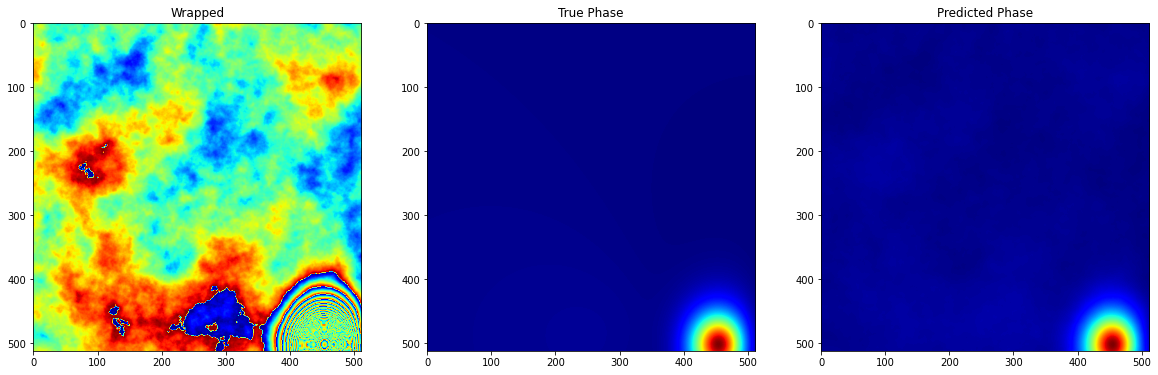

In [99]:
display_images(phase, wrapped_with_turb, pred_phase_with_turb)

#### Unwrapping with Error from Topographic Atmospheric Effects

In [100]:
simulated_topography = gen_fake_topo(size=tile_size, alt_scale_min=25, alt_scale_max=50)
topo_phase = np.abs(atm_topo_simulate(simulated_topography) * atmosphere_scalar * np.pi)
phase_with_topo = phase + topo_phase
wrapped_with_topo = np.angle(np.exp(1j * (phase_with_topo)))
pred_phase_with_topo = unwrap_with_snaphu(
    wrapped_with_topo, quiet=True, delete_files=True
)

Max/Min Phase:   164.9254391446654 -1.126159141006029
Max/Min SNAPHU:  166.1005 -1.0804565
Max Diff:  1.175055240100221
Min Diff:  0.045702645720994806


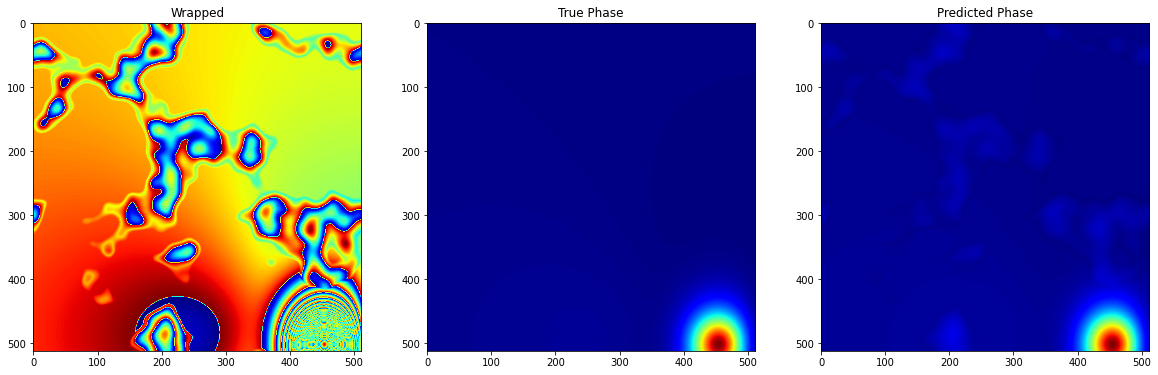

In [101]:
display_images(phase, wrapped_with_topo, pred_phase_with_topo)

#### Unwrapping with Error from Both Topographic and Turbulent Sources

In [102]:
phase_turb_topo = phase + topo_phase + turb_phase
wrapped_turb_topo = np.angle(np.exp(1j * phase_turb_topo))
pred_phase_turb_topo = unwrap_with_snaphu(
    wrapped_turb_topo, quiet=True, delete_files=True
)

Max/Min Phase:   164.9254391446654 -1.126159141006029
Max/Min SNAPHU:  166.11794 -1.96335
Max Diff:  1.1924960359986585
Min Diff:  0.8371909165958997


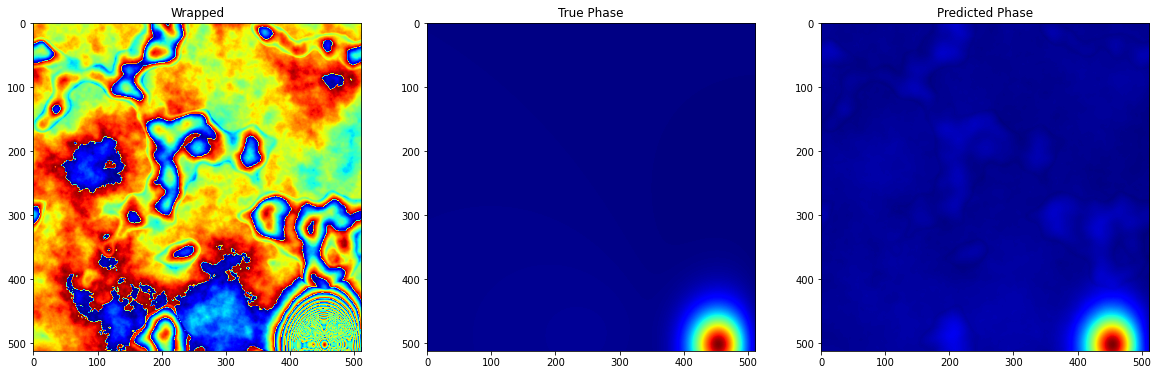

In [103]:
display_images(phase, wrapped_turb_topo, pred_phase_turb_topo)

#### Unwrapping with Gaussian Noise

In [104]:
noise_threshold = 10 * np.pi
noise_phase = gen_gaussian_noise(
    tile_size=tile_size, seed=seed, threshold=noise_threshold
)
phase_with_noise = phase + noise_phase
wrapped_with_noise = np.angle(np.exp(1j * phase_with_noise))
pred_phase_with_noise = unwrap_with_snaphu(
    wrapped_with_noise, quiet=True, delete_files=True
)

Max/Min Phase:   164.9254391446654 -1.126159141006029
Max/Min SNAPHU:  152.96875 -4.779655
Max Diff:  11.956689144665404
Min Diff:  3.6534958386997816


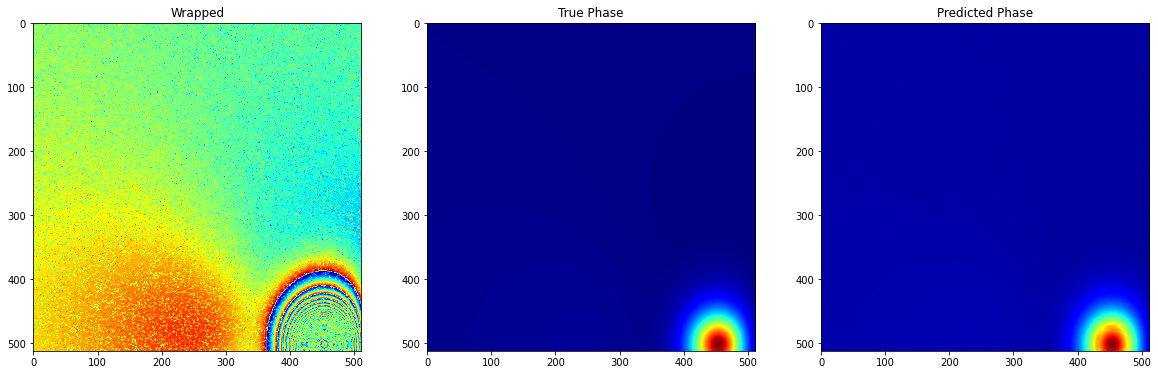

In [105]:
display_images(phase, wrapped_with_noise, pred_phase_with_noise)

#### Unwrapping with All Error Sources

In [106]:
phase_all = phase + topo_phase + turb_phase + noise_phase
wrapped_all = np.angle(np.exp(1j * phase_all))
pred_phase_all = unwrap_with_snaphu(wrapped_all, quiet=True, delete_files=True)

Max/Min Phase:   164.9254391446654 -1.126159141006029
Max/Min SNAPHU:  154.38176 -4.5742807
Max Diff:  10.543679501110717
Min Diff:  3.4481215978245374


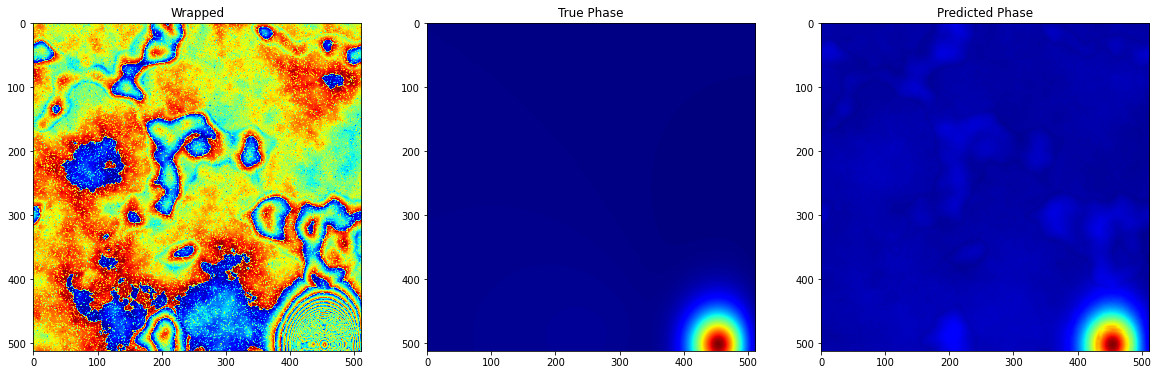

In [107]:
display_images(phase, wrapped_all, pred_phase_all)